Remove uneccesary columns and delete any rows with missing data. 8% of articles are missing an abstract, these article rows are dropped.

In [1]:
import numpy as np 
import pandas as pd 
import spacy

import plotly.graph_objs as go
# these two lines allow your code to show up in a notebook
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import collections

data=pd.read_csv("../input/neuroscience_articles.csv")
data['citation_online_date']=pd.to_datetime(data['citation_online_date'],format="%Y/%M/%d")
data['citation_year']=data['citation_online_date'].dt.year

# Replace empty abstract (' ') with Na
data['citation_abstract']=data['citation_abstract'].fillna(' ')
data=data.drop(['citation_doi', 'citation_pdf_url', 'dc.identifier', 'citation_author_email', 'citation_language', 'citation_publisher'], 1)
data=data.dropna()

# Overview

In [2]:
# Find the time range of the articles
time = data['citation_online_date'].sort_values()
articles = data.shape[0]

"Number of articles: {0} Newest: {1} Oldest: {2}".format(articles, time.iloc[-1], time.iloc[0])

'Number of articles: 15803 Newest: 2019-01-31 00:01:00 Oldest: 2010-01-01 00:03:00'

Number of articles published in each country.

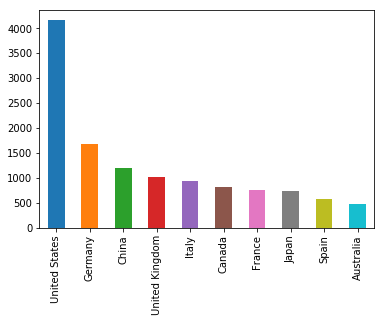

In [3]:
data['citation_country'] = data['citation_author_institution'].apply(lambda x: x.split(',')[-1].strip())
data['citation_country'] = data['citation_country'].replace({'USA': 'United States', 'UK': 'United Kingdom'})

# Number of neurosceince papers published in each country
journal_type_freq = data['citation_country'].value_counts().head(10).plot.bar()


Heatmap of journals in the Frontiers in Neuroscience series topis, countries, and number of articles.

In [4]:
# Get a list of top 11 countries
countries = data['citation_country'].value_counts().head(11)

# Get research category and country counts. Reset index to have a research category for every row.
countries_journal_types = data.groupby(["citation_journal_title", 'citation_country']).size().reset_index()

# Get the rows containing the top n countries
countries_journal_types = countries_journal_types.loc[countries_journal_types['citation_country'].isin(countries.index)].reset_index(drop=True)
countries_journal_types.set_axis(['citation_journal_title', 'citation_country', 'count'], axis='columns', inplace=True)

countries_journal_types = countries_journal_types.pivot(index='citation_journal_title', columns='citation_country', values='count').fillna(0)

trace = go.Heatmap(z=countries_journal_types.values.transpose(),
                   y=list(countries_journal_types.columns.values),
                   x=list(countries_journal_types.index), colorscale='Viridis')

layout = go.Layout(
    margin = dict(t=25,r=20,b=170,l=115),
)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig, filename='datetime-heatmap')

# Persistent Themes
To get an idea of what are some of the common research topics, I followed a general approach of doing frequency counts, of unigrams, bigrams and trigrams for all of the articles as well as for each year. Can see that BCI is one of the popular ones. Will investegate the popularity of BCI's later.

In [5]:
import sklearn.feature_extraction.text as text
def get_imp(bow,mf,ngram):
    tfidf=text.CountVectorizer(bow,ngram_range=(ngram,ngram),max_features=mf,stop_words='english')
    matrix=tfidf.fit_transform(bow)
    return pd.Series(np.array(matrix.sum(axis=0))[0],index=tfidf.get_feature_names()).sort_values(ascending=False).head(150)

# Global trends
bow=data['citation_abstract'].tolist()
total_data=get_imp(bow,mf=5000,ngram=1)
total_data_bigram=get_imp(bow=bow,mf=5000,ngram=2)
total_data_trigram=get_imp(bow=bow,mf=5000,ngram=3)

# Yearly trends
yearly_unigram_dict ={}
for y in data['citation_year'].unique():
    bow=data[data['citation_year']==y]['citation_abstract'].tolist()
    yearly_unigram_dict[y]=get_imp(bow,mf=5000,ngram=1)
    
yearly_bigram_dict={}
for y in data['citation_year'].unique():
    bow=data[data['citation_year']==y]['citation_abstract'].tolist()
    yearly_bigram_dict[y]=get_imp(bow,mf=5000,ngram=2)
    
yearly_trigram_dict={}
for y in data['citation_year'].unique():
    bow=data[data['citation_year']==y]['citation_abstract'].tolist()
    yearly_trigram_dict[y]=get_imp(bow,mf=5000,ngram=3)

Bigrams and trigrams for all of the articles in the Frontiers in Neuroscience journal series.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

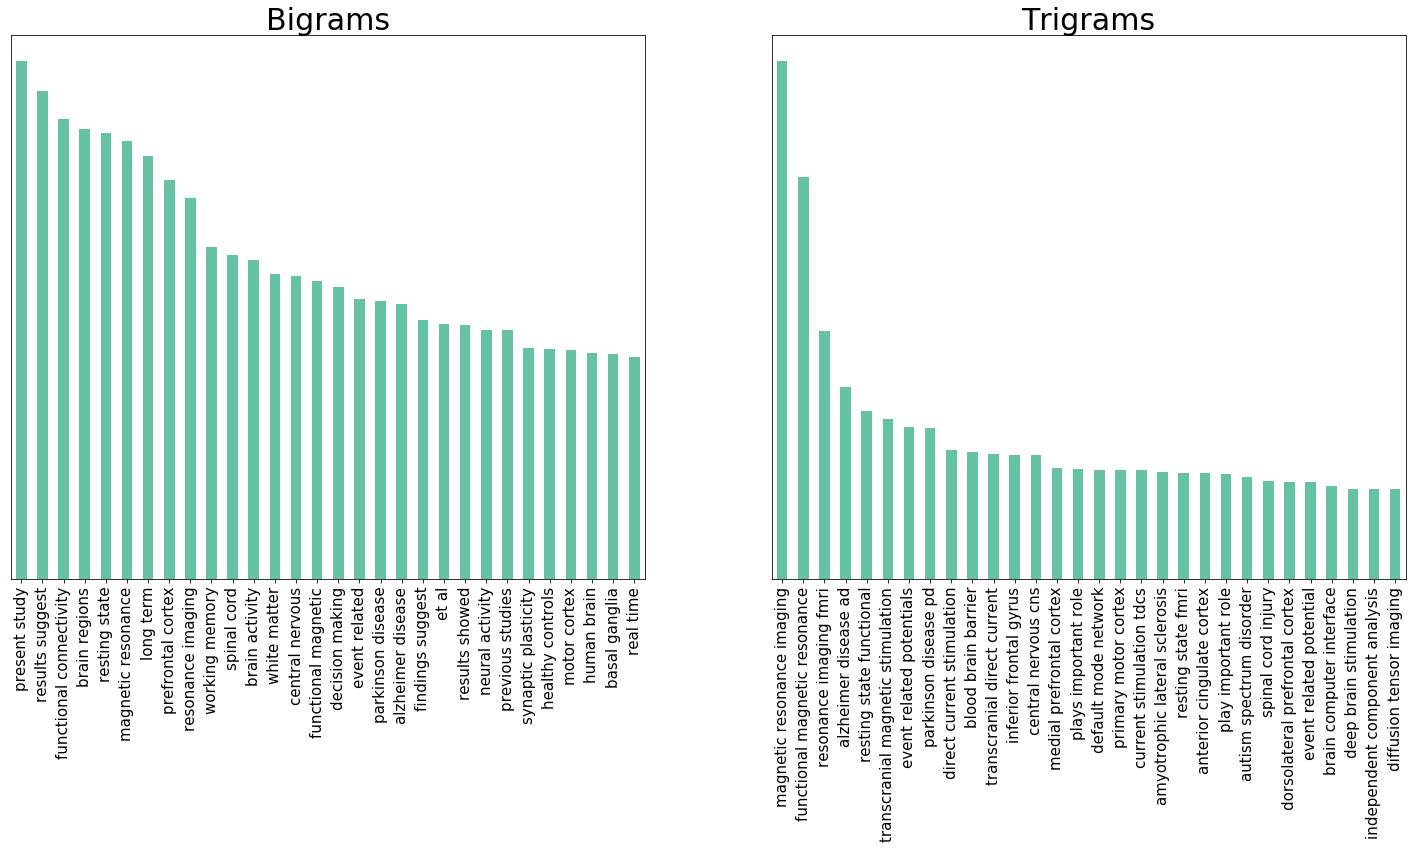

In [6]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
total_data_bigram.head(30).plot(kind="bar",figsize=(25,10),colormap='Set2')
plt.title("Bigrams",fontsize=30)
plt.yticks([])
plt.xticks(size=15)
plt.subplot(1,2,2)
total_data_trigram.head(30).plot(kind="bar",figsize=(25,10),colormap='Set2')
plt.title("Trigrams",fontsize=30)
plt.yticks([])
plt.xticks(size=15)

Plot of most common bigrams over the years. Can see shifts in research focus, for exmaple basal ganglia to prefrontal cortex.

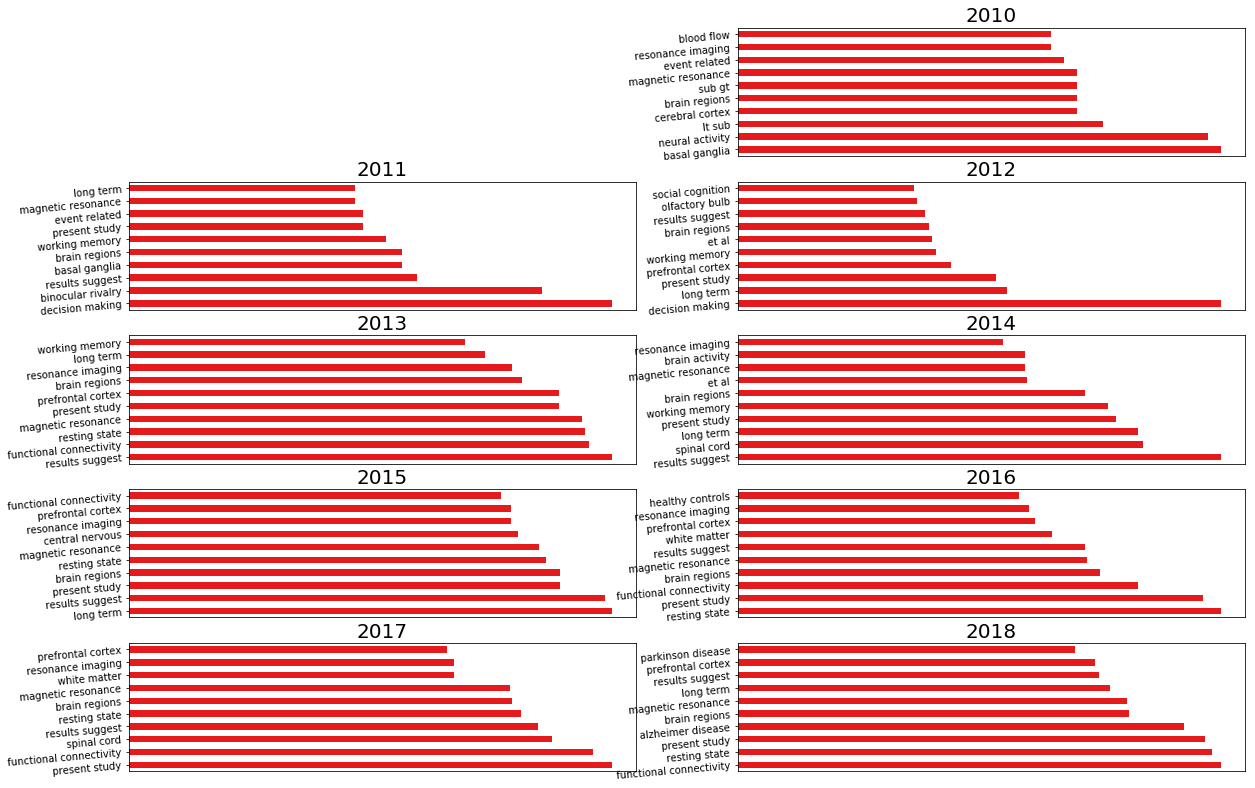

In [7]:
for i in range(10,19,1):
    plt.subplot(9,2,i)
    yearly_bigram_dict[2000+i].head(10).plot(kind="barh",figsize=(20,25),colormap='Set1')
    plt.title(2000+i,fontsize=20)
    plt.xticks([])
    plt.yticks(size=10,rotation=5)

Find most common citation keywords.

In [8]:
keywords_analysis = data.copy()
keywords_analysis['citation_keywords'] = keywords_analysis['citation_keywords'].apply(lambda x: [a.strip() for a in x.lower().split(';')])
all_keywords = (list([a for b in keywords_analysis.citation_keywords.tolist() for a in b]))

counter = collections.Counter(all_keywords)
all_keywords = sorted( all_keywords, key=counter.get, reverse=True )

[[a, counter.get(a)] for a in list(collections.OrderedDict.fromkeys(all_keywords))][:15]

[['fmri', 751],
 ['eeg', 489],
 ['hippocampus', 461],
 ['functional connectivity', 299],
 ['attention', 280],
 ['dopamine', 277],
 ['schizophrenia', 254],
 ['development', 250],
 ['stroke', 234],
 ['microglia', 231],
 ['plasticity', 224],
 ['aging', 206],
 ['working memory', 204],
 ['alzheimer’s disease', 198],
 ['neurogenesis', 198]]

Analyze mentions of mental health keywords in citation abstracts over time.

In [9]:
keywords = ['alzheimer’s disease', 'parkinson’s disease', 'schizophrenia', 'depression', 'epilepsy']

# Create a list of keyword, and a pandas series of all the rows that mention that keyword
indeces = [[keyword, data['citation_abstract'].str.contains(keyword,case=False)] for keyword in keywords]

for keyword in indeces:
    print("{0} has been mentioned in {1} abstracts".format(keyword[0], np.sum(keyword[1])))

alzheimer’s disease has been mentioned in 370 abstracts
parkinson’s disease has been mentioned in 375 abstracts
schizophrenia has been mentioned in 350 abstracts
depression has been mentioned in 480 abstracts
epilepsy has been mentioned in 322 abstracts


Text(0.5, 1.0, 'Mentions of Mental Health Keywords in Citation Abstracts over time')

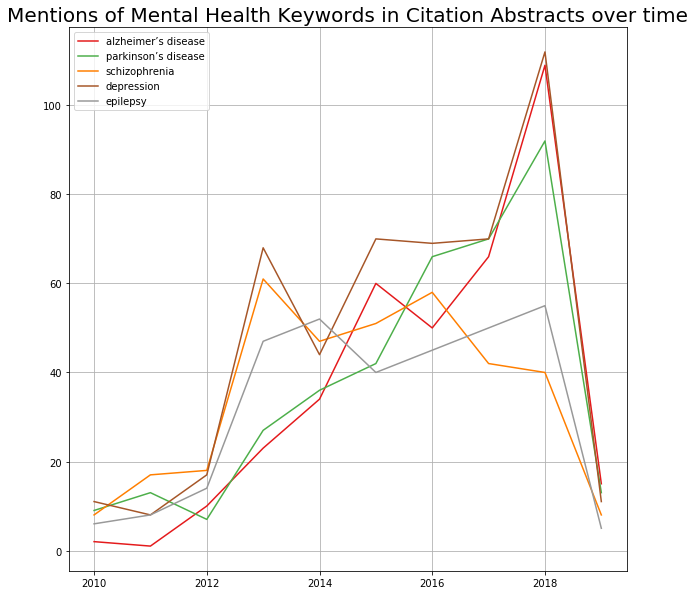

In [10]:
counts = []
for keyword in indeces:
    counts.append(pd.DataFrame(data['citation_year'].loc[keyword[1]].value_counts()))
    
n_r=pd.concat(counts,axis=1)
n_r.columns=keywords
n_r.plot(figsize=(10,10), kind='line', colormap= 'Set1', grid=True)
plt.title("Mentions of Mental Health Keywords in Citation Abstracts over time",fontsize=20)


Word clouds for citation abstracts containing mental health keywords.

(-0.5, 4999.5, 2499.5, -0.5)

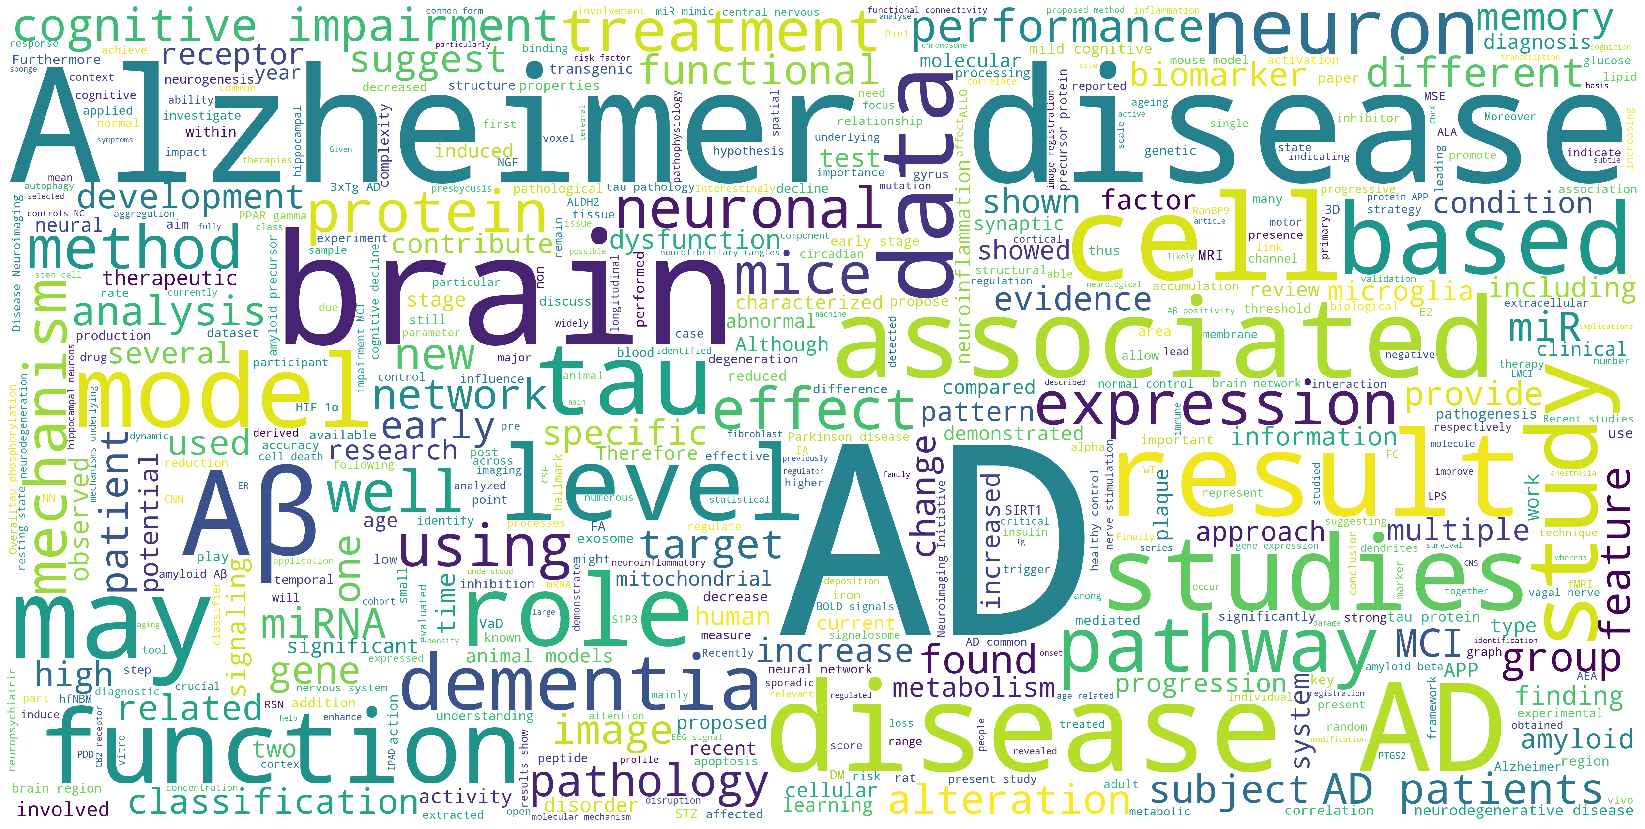

In [11]:
alz_index= data['citation_abstract'].str.contains("alzheimer's",case=False)
data_alz=data.loc[alz_index].copy()
text=" ".join(data_alz['citation_abstract'].tolist())

from wordcloud import WordCloud,STOPWORDS
wc = WordCloud(max_words=500,width=5000,height=2500,background_color="white",stopwords=STOPWORDS).generate(text)
plt.figure( figsize=(30,15) )
plt.imshow(wc)
plt.yticks([])
plt.xticks([])
plt.axis("off")

(-0.5, 4999.5, 2499.5, -0.5)

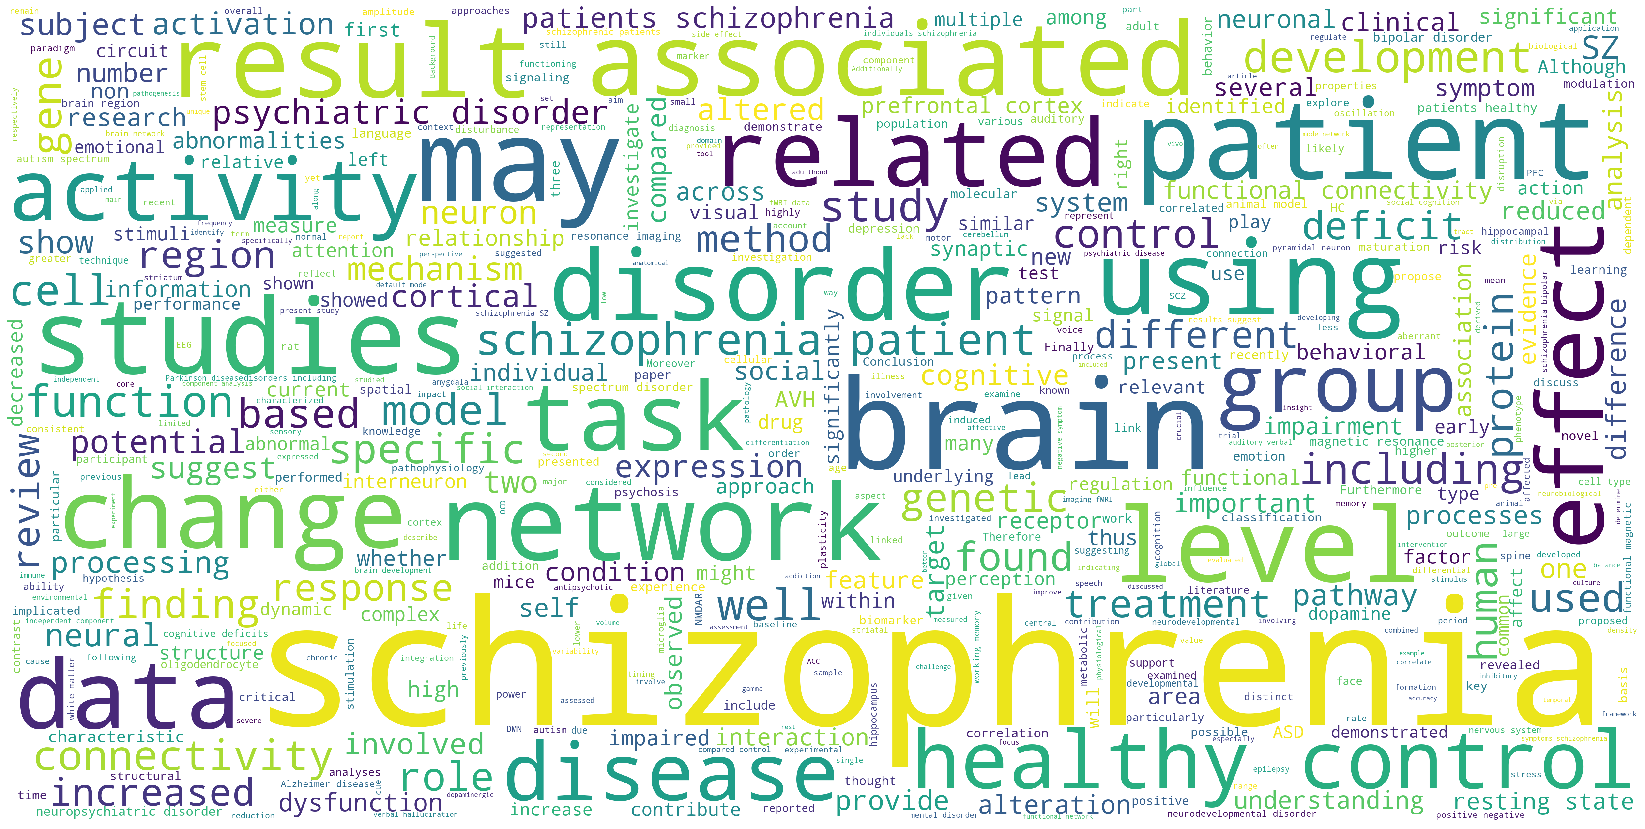

In [12]:
alz_index= data['citation_abstract'].str.contains("schizophrenia",case=False)
data_alz=data.loc[alz_index].copy()
text=" ".join(data_alz['citation_abstract'].tolist())

from wordcloud import WordCloud,STOPWORDS
wc = WordCloud(max_words=500,width=5000,height=2500,background_color="white",stopwords=STOPWORDS).generate(text)
plt.figure( figsize=(30,15) )
plt.imshow(wc)
plt.yticks([])
plt.xticks([])
plt.axis("off")

Plot the percentage change of top 10 most common trigrams over the years. Can see which years there was a spike in a specific research theme.

Text(0, 0.5, 'Percent change')

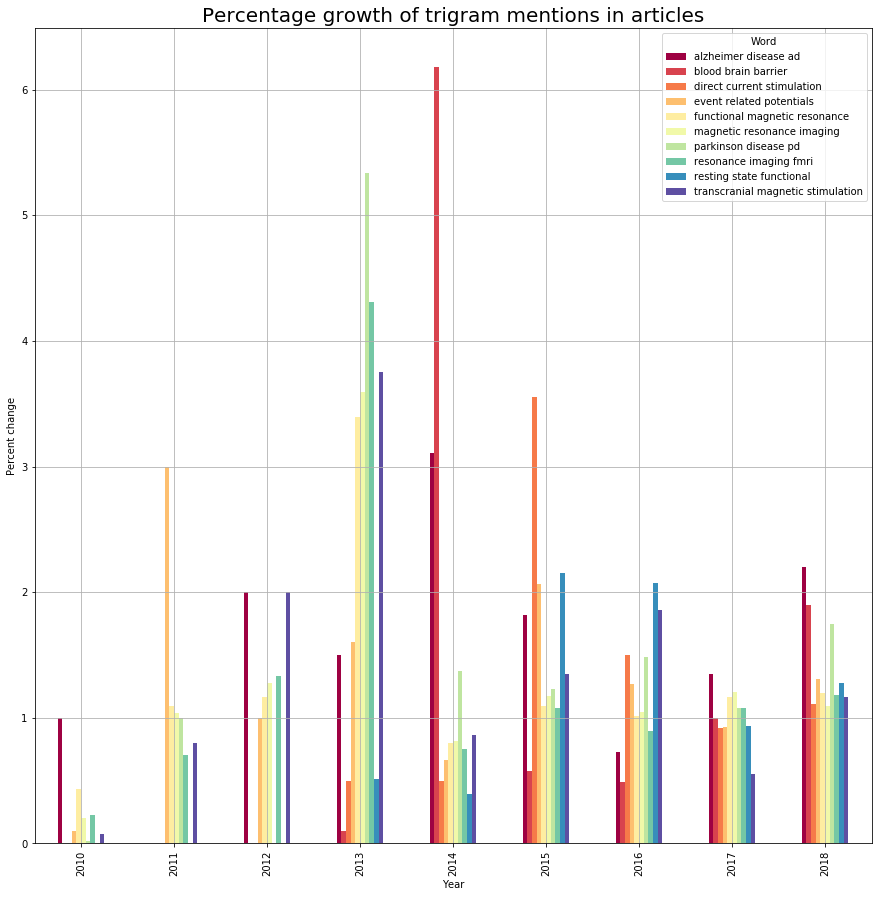

In [13]:
word_counts_years = {}

for i in range(9):
    year = 2010 + i
    series = yearly_trigram_dict[year]
    
    # Create data frame from pandas Series
    word_counts_years[year] = pd.DataFrame({'Word':series.index, 'Count':series, 'Year': year}).reset_index(drop=True)

# Stack the frames on top of each other
df_final = pd.concat([df for df in word_counts_years.values()], ignore_index = True)

# Get the Rows containing word that are in the top 20 most common words
df_final = df_final.loc[df_final['Word'].isin(total_data_trigram.head(10).index)]

# Sort common words together, year acesding
df_final = df_final.sort_values(['Word', 'Year'])

# Set indeces and calculate percent change in count, https://stackoverflow.com/questions/41453325/python-pandas-groupby-calculate-change
df_final = df_final.set_index(['Year', 'Word']).Count
df_final = df_final.groupby('Word').pct_change()

df_final.fillna(0).add(1).unstack().plot(figsize=(15,15), kind='bar', colormap= 'Spectral', grid=True)
plt.title("Percentage growth of trigram mentions in articles",fontsize=20)
plt.ylabel("Percent change")

# BCI Trends

Only keep articles that have citation absracts that contain specific keywords

In [14]:
import re

keywords = ['bci', 'brain computer', 'neocortex', 'EEG', 'electroencephalography', 'brain-machine']

# Create a list of keyword, and a pandas series of all the rows that mention that keyword
indeces = [[keyword, data['citation_abstract'].str.contains(keyword,case=False)] for keyword in keywords]

for keyword in indeces:
    print("{0} has been mentioned in {1} citation abstracts".format(keyword[0], np.sum(keyword[1])))

bci has been mentioned in 235 citation abstracts
brain computer has been mentioned in 50 citation abstracts
neocortex has been mentioned in 183 citation abstracts
EEG has been mentioned in 997 citation abstracts
electroencephalography has been mentioned in 307 citation abstracts
brain-machine has been mentioned in 52 citation abstracts


Word cloud of BCI terms. Searching multiple strings [Pandas regex string match](https://stackoverflow.com/questions/22623977/searching-multiple-strings-in-pandas-without-predefining-number-of-strings-to-us).
Keep only BCI spefific journals, drop the rest

(-0.5, 4999.5, 2499.5, -0.5)

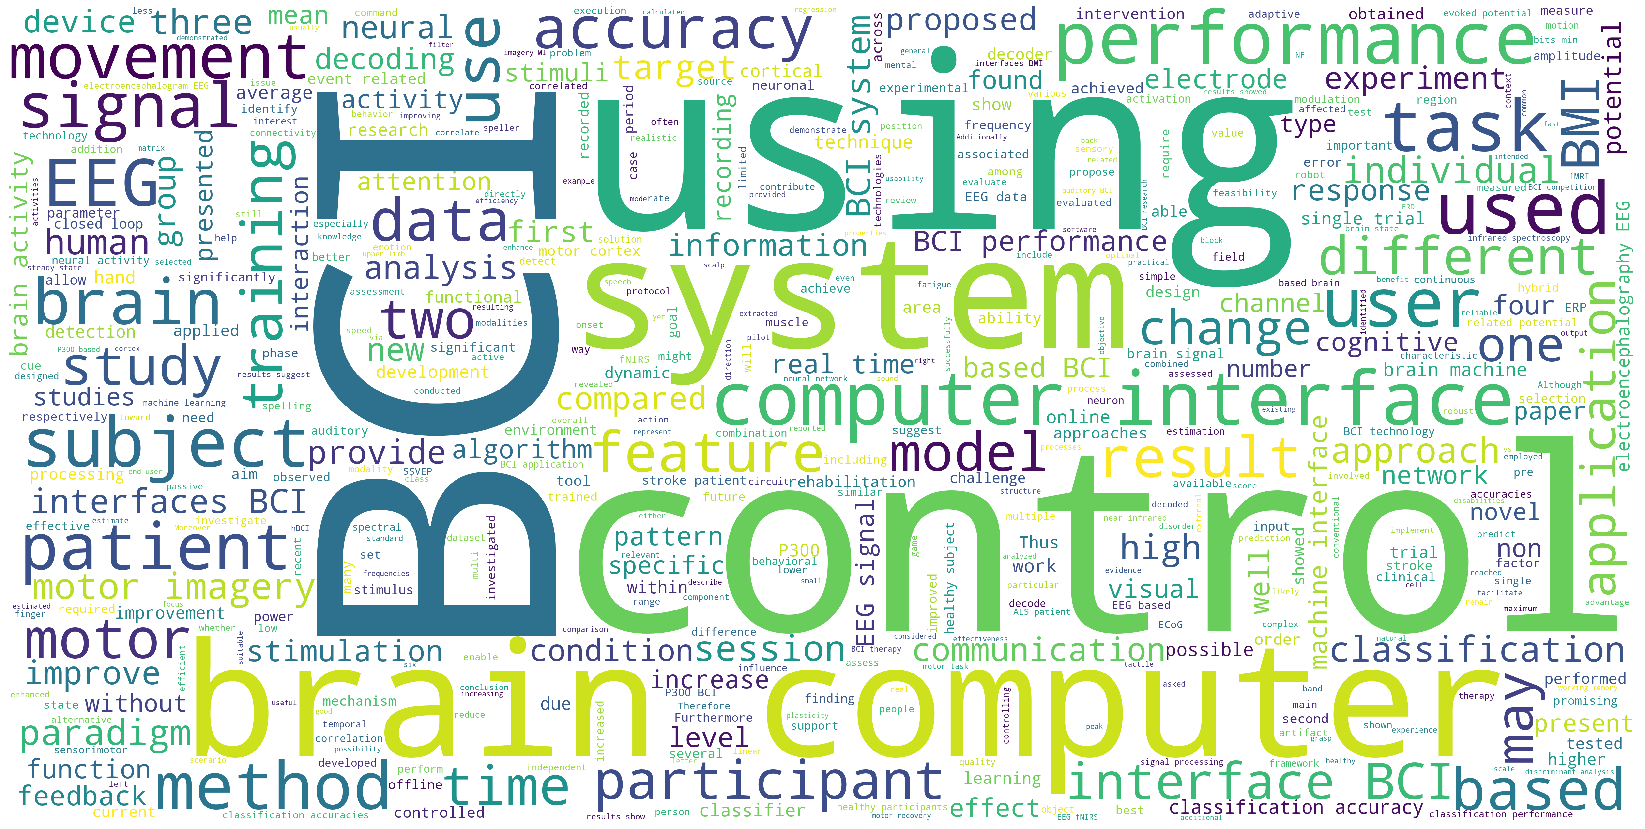

In [15]:
import re

key = ['bci', 'brain computer interface','brain-machine interface']
pattern = '|'.join(map(re.escape, key))

bci_index= data['citation_abstract'].str.contains(pattern,case=False)
data=data.loc[bci_index].copy()
text=" ".join(data['citation_abstract'].tolist())

from wordcloud import WordCloud,STOPWORDS
wc = WordCloud(max_words=500,width=5000,height=2500,background_color="white",stopwords=STOPWORDS).generate(text)
plt.figure( figsize=(30,15) )
plt.imshow(wc)
plt.yticks([])
plt.xticks([])
plt.axis("off")

Unigram, bigram, trigram analysis for BCI specific articles.

In [16]:
import sklearn.feature_extraction.text as text
def get_imp(bow,mf,ngram):
    tfidf=text.CountVectorizer(bow,ngram_range=(ngram,ngram),max_features=mf,stop_words='english')
    matrix=tfidf.fit_transform(bow)
    return pd.Series(np.array(matrix.sum(axis=0))[0],index=tfidf.get_feature_names()).sort_values(ascending=False).head(150)

# Global trends
bow=data['citation_abstract'].tolist()
total_data=get_imp(bow,mf=5000,ngram=1)
total_data_bigram=get_imp(bow=bow,mf=5000,ngram=2)
total_data_trigram=get_imp(bow=bow,mf=5000,ngram=3)

# Yearly trends
yearly_unigram_dict ={}
for y in data['citation_year'].unique():
    bow=data[data['citation_year']==y]['citation_abstract'].tolist()
    yearly_unigram_dict[y]=get_imp(bow,mf=5000,ngram=1)
    
yearly_bigram_dict={}
for y in data['citation_year'].unique():
    bow=data[data['citation_year']==y]['citation_abstract'].tolist()
    yearly_bigram_dict[y]=get_imp(bow,mf=5000,ngram=2)
    
yearly_trigram_dict={}
for y in data['citation_year'].unique():
    bow=data[data['citation_year']==y]['citation_abstract'].tolist()
    yearly_trigram_dict[y]=get_imp(bow,mf=5000,ngram=3)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

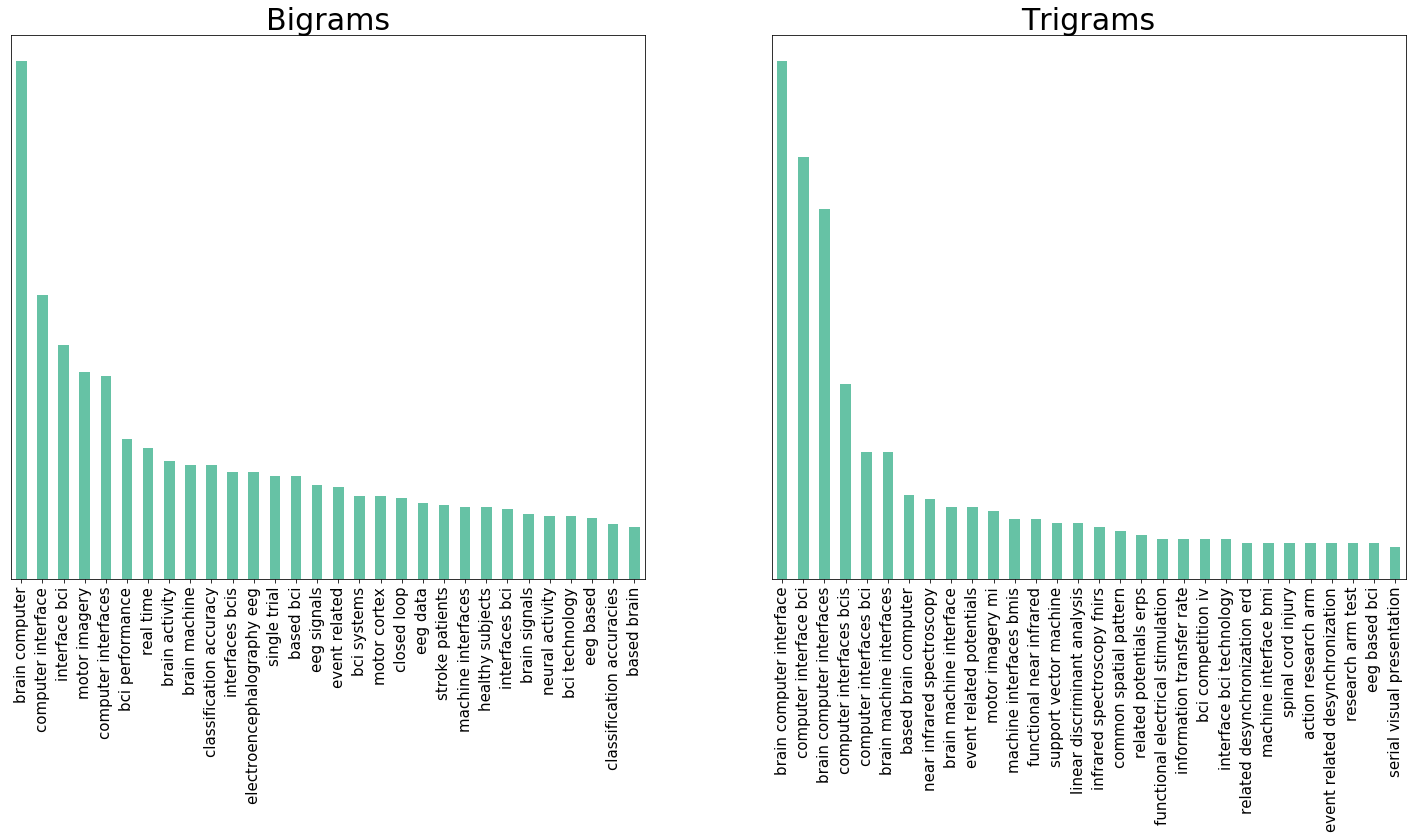

In [17]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
total_data_bigram.head(30).plot(kind="bar",figsize=(25,10),colormap='Set2')
plt.title("Bigrams",fontsize=30)
plt.yticks([])
plt.xticks(size=15)
plt.subplot(1,2,2)
total_data_trigram.head(30).plot(kind="bar",figsize=(25,10),colormap='Set2')
plt.title("Trigrams",fontsize=30)
plt.yticks([])
plt.xticks(size=15)

Trigrams over the years for BCI specific articles.

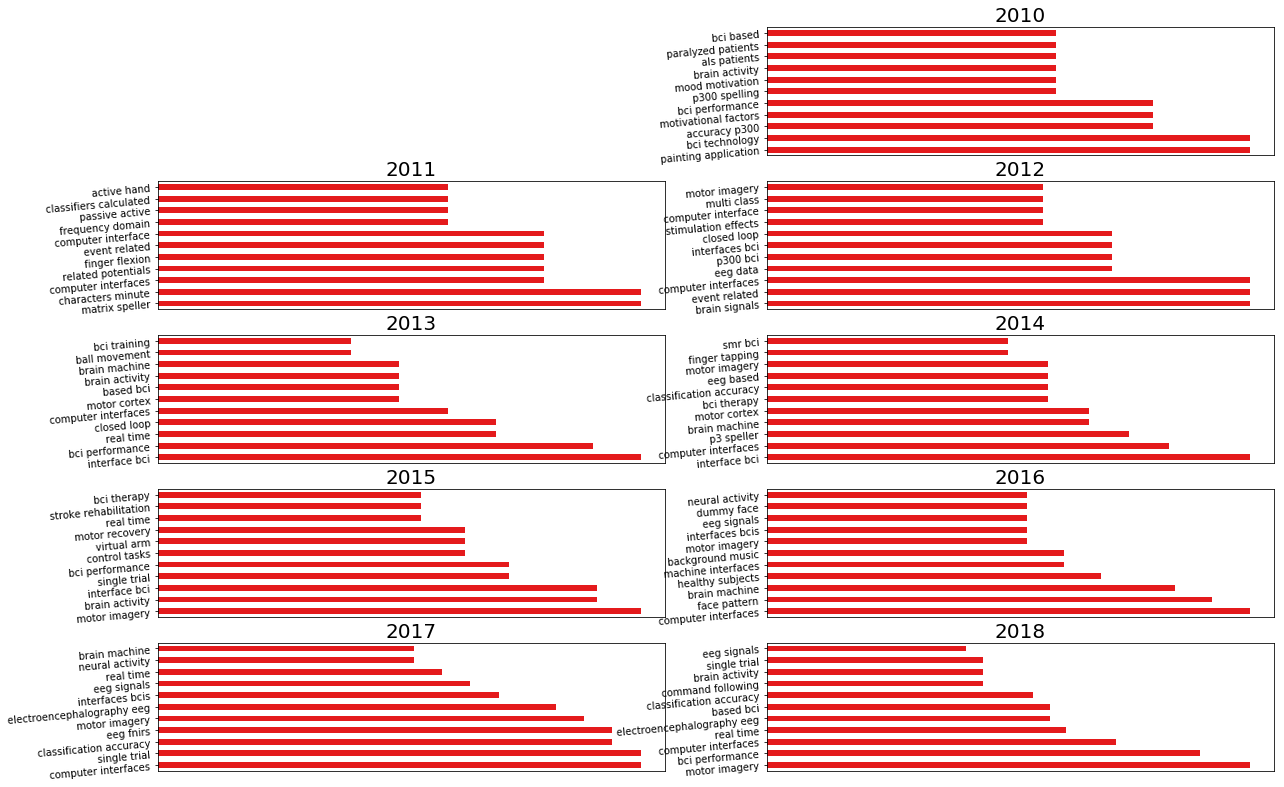

In [18]:
for i in range(10,19,1):
    plt.subplot(9,2,i)
    yearly_bigram_dict[2000+i][3:14].plot(kind="barh",figsize=(20,25),colormap='Set1')
    plt.title(2000+i,fontsize=20)
    plt.xticks([])
    plt.yticks(size=10,rotation=5)

Percent change in BCI specific article trigram mentions over time.

Text(0, 0.5, 'Percent change')

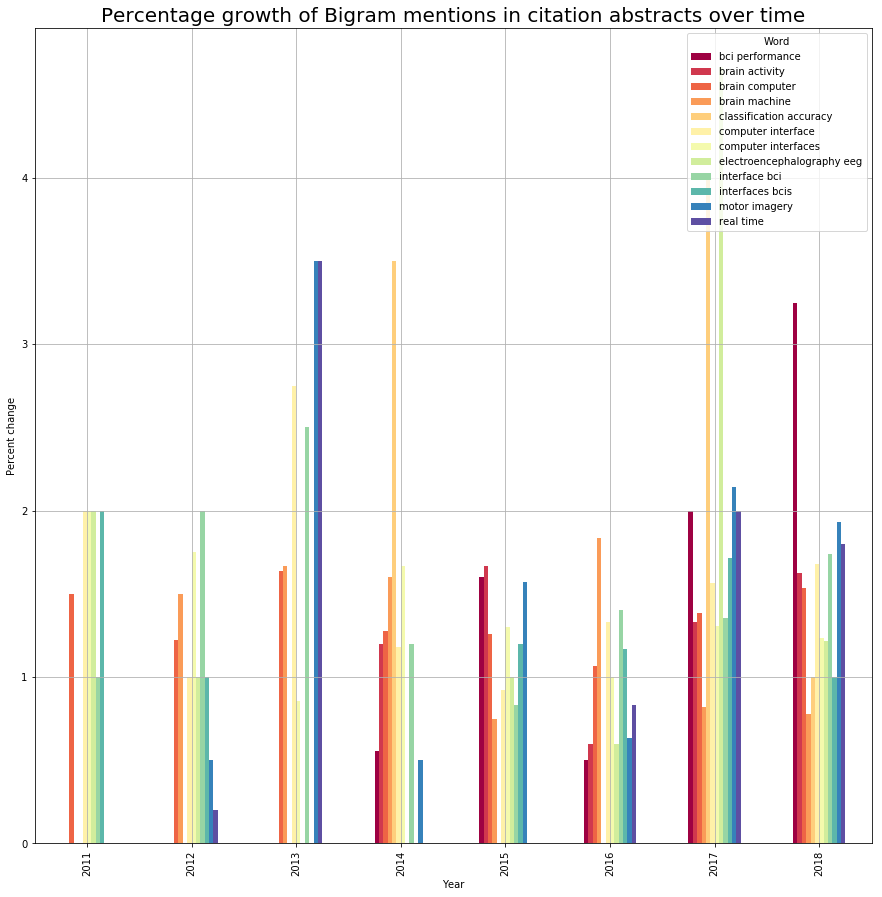

In [19]:
word_counts_years = {}

for i in range(9):
    year = 2010 + i
    series = yearly_bigram_dict[year]
    
    # Create data frame from pandas Series
    word_counts_years[year] = pd.DataFrame({'Word':series.index, 'Count':series, 'Year': year}).reset_index(drop=True)
    
# Stack the frames on top of each other
df_final = pd.concat([df for df in word_counts_years.values()], ignore_index = True)

# Get the Rows containing word that are in the top 20 most common words
df_final = df_final.loc[df_final['Word'].isin(total_data_bigram[:12].index)]

# Pivot Dataframe so words become columns, and can set a word not present in a year to 0
df_final = df_final.pivot_table('Count', ['Year'], 'Word').fillna(0)
df_final = df_final.pct_change()

# # Stack again
df_final = df_final.stack().rename_axis((['Year', 'Word'])).reset_index(name='Change')

# Set indeces and calculate percent change in count
df_final = df_final.set_index(['Year', 'Word']).Change

df_final.fillna(0).add(1).unstack().plot(figsize=(15,15), kind='bar', colormap= 'Spectral', grid=True)
plt.title("Percentage growth of Bigram mentions in citation abstracts over time",fontsize=20)
plt.ylabel("Percent change")